<a href="https://colab.research.google.com/github/springboardmentor2468a-lab/AgriYield/blob/TAMILARASAN/AgriYield_Predictor_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**AgriYield Predictor: Forecasting Crop Yield Using Environmental and Soil Data**

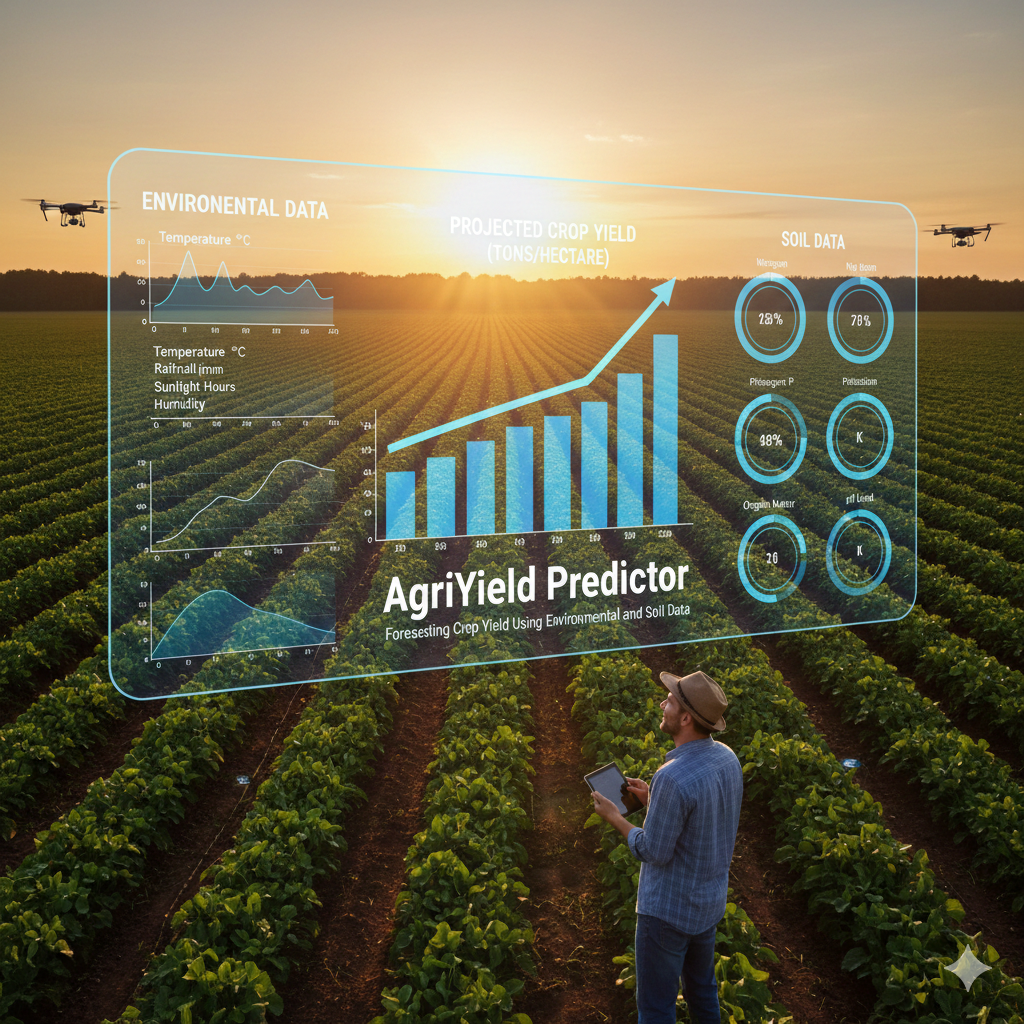

#**Milestone 1: Week 1 & 2 — Requirements & Dataset Preparation**

# **Project Overview & Scope**

**Project Objective**

Develop a machine learning model that can accurately predict crop yield (kg/hectare) for different crops grown in various regions, based on soil and environmental data.

**Project Scope**

This project will include:


| Task                       | Includes                                     | Tools Used          |
| -------------------------- | -------------------------------------------- | ------------------- |
| Data Collection & Cleaning | Integrating soil, crop, and climate datasets | Python (Pandas)     |
| EDA & Feature Engineering  | Trends, correlations, engineered features    | Matplotlib, Seaborn |
| Model Training             | Regression models                            | Sklearn, XGBoost    |
| Performance Evaluation     | RMSE, MAE, R² score                          | Sklearn metrics     |
| Deployment                 | Simple UI for farmers                        | Streamlit / Flask   |


####**Architectural diagram**

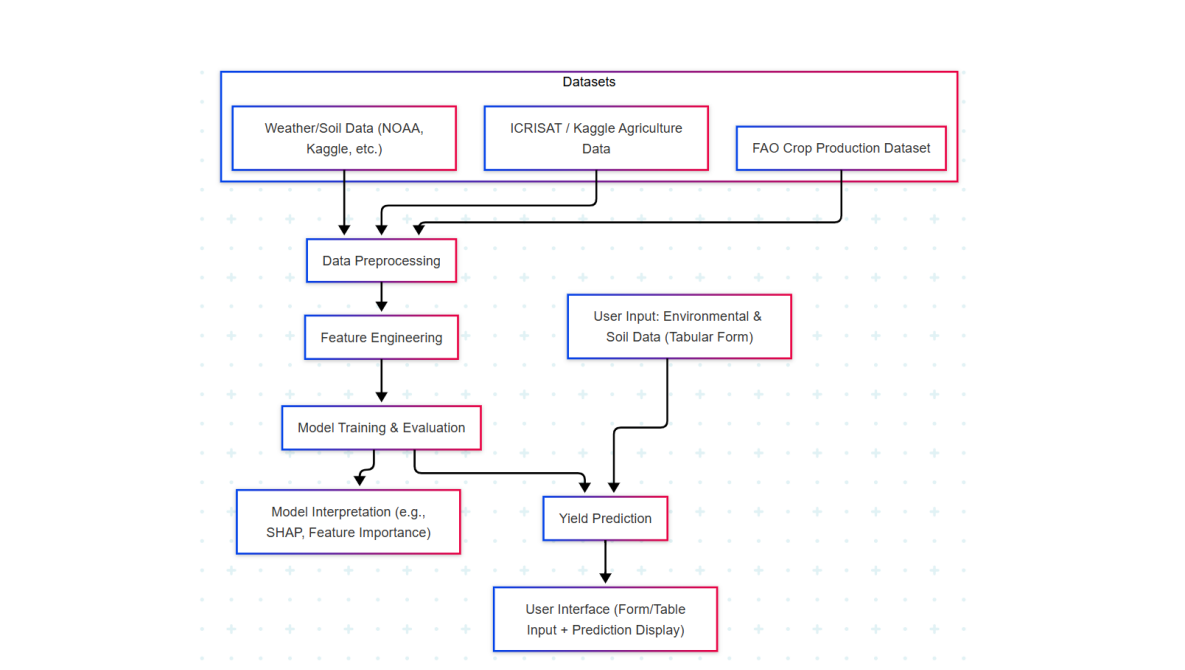

#**Import Required Libraries**


In [24]:
import numpy as np            # For numerical operations
import pandas as pd           # For data loading & preprocessing
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns            # For statistical visualizations

from sklearn.model_selection import train_test_split

#**Load Raw Datasets**

In [31]:
# Load the first dataset (FAOSTAT data)
faostat_df = pd.read_csv("DF_1_FAOSTAT_data_en_11-19-2025.csv")

In [32]:
# Load the second dataset (Crop Recommendation data)
crop_rec_df = pd.read_csv("DF_2_Crop_recommendation.csv")

In [34]:
print("FAOSTAT DATASET:")
print(faostat_df.head())

FAOSTAT DATASET:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha   
2  

In [35]:
print("\nCROP RECOMMENDATION DATASET:")
print(crop_rec_df.head())


CROP RECOMMENDATION DATASET:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice


In [36]:
print("\nFAOSTAT shape:", faostat_df.shape)
print("Crop Recommendation shape:", crop_rec_df.shape)


FAOSTAT shape: (5940, 15)
Crop Recommendation shape: (2200, 8)


#**Initial Data Inspection**

In [137]:
def inspect_dataset(df, name):
    print(f"\n Dataset Inspection: {name}")
    print("-" * 60)

    # 1️ First few records
    print("\n First 5 rows:")
    display(df.head())

    # 2️ Dataset shape
    print("\n Shape (Rows, Columns):")
    print(df.shape)

    # 3️ Basic information
    print("\n Basic Info:")
    df.info()

    # 4️ Missing values
    print("\n Missing Values:")
    print(df.isnull().sum().sort_values(ascending=False).to_markdown(numalign="left", stralign="left"))

    # 5️ Duplicate rows
    print("\n Duplicate Rows:")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")

    # 6 Duplicate columns
    print("\n Duplicate columns:")
    print(f"Number of duplicate columns: {df.duplicated().sum()}")

    # 7 Descriptive statistics for numerical columns
    print("\n  Descriptive Statistics:")
    print(df.describe().to_markdown(numalign="left", stralign="left"))

    # 8 Unique values for categorical columns (top 10)
    print("\n Unique Values (Top 10 for Object/Category Dtype Columns):")
    for col in df.select_dtypes(include=['object', 'category']).columns:
        print(f"  - {col}:")
        print(df[col].value_counts().head(10).to_markdown(numalign="left", stralign="left"))
        print("\n")

# Now, let's call the function for each dataframe
inspect_dataset(faostat_df, "FAOSTAT Dataset")
inspect_dataset(crop_rec_df, "Crop Recommendation Dataset")


 Dataset Inspection: FAOSTAT Dataset
------------------------------------------------------------

 First 5 rows:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),crop,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,anise,2000,2000,ha,344434.0,A,Official figure,Unknown
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,anise,2000,2000,kg/ha,484.0,A,Official figure,Unknown
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,anise,2000,2000,t,166692.0,A,Official figure,Unknown
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,anise,2001,2001,ha,569271.0,A,Official figure,Unknown
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,anise,2001,2001,kg/ha,430.3,A,Official figure,Unknown



 Shape (Rows, Columns):
(5940, 15)

 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       5940 non-null   object 
 1   Domain            5940 non-null   object 
 2   Area Code (M49)   5940 non-null   int64  
 3   Area              5940 non-null   object 
 4   Element Code      5940 non-null   int64  
 5   Element           5940 non-null   object 
 6   Item Code (CPC)   5940 non-null   float64
 7   crop              5940 non-null   object 
 8   Year Code         5940 non-null   int64  
 9   Year              5940 non-null   int64  
 10  Unit              5940 non-null   object 
 11  Value             5940 non-null   float64
 12  Flag              5940 non-null   object 
 13  Flag Description  5940 non-null   object 
 14  Note              5940 non-null   object 
dtypes: float64(2), int64(4), object(9)
memo

,N,P,K,temperature,humidity,ph,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice



 Shape (Rows, Columns):
(2200, 8)

 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB

 Missing Values:
|             | 0   |
|:------------|:----|
| N           | 0   |
| P           | 0   |
| K           | 0   |
| temperature | 0   |
| humidity    | 0   |
| ph          | 0   |
| rainfall    | 0   |
| crop        | 0   |

 Duplicate Rows:
Number of duplicate rows: 0

 Duplicate columns:
Number of duplicate columns: 0

  Descriptive Statistics

#**Data Cleaning & Formatting**

In [69]:
# Remove duplicate rows
faostat_df.drop_duplicates(inplace=True)
crop_rec_df.drop_duplicates(inplace=True)

In [98]:
# Check missing values
print("Missing values in FAOSTAT dataset:")
print(faostat_df.isnull().sum())

print("\nMissing values in Crop Recommendation dataset:")
print(crop_rec_df.isnull().sum())

Missing values in FAOSTAT dataset:
Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
crop                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
Note                0
dtype: int64

Missing values in Crop Recommendation dataset:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
crop           0
dtype: int64


In [72]:
# Show updated shapes
print("\nFAOSTAT shape:", faostat_df.shape)
print("Crop Recommendation shape:", crop_rec_df.shape)



FAOSTAT shape: (5940, 15)
Crop Recommendation shape: (2200, 8)


In [73]:
# Preview updated data
print("\nFAOSTAT first 5 rows:")
display(faostat_df.head())


FAOSTAT first 5 rows:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,kg/ha,484.0,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,t,166692.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,ha,569271.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,kg/ha,430.3,A,Official figure,NaN


In [74]:
print("\nCrop Recommendation first 5 rows:")
display(crop_rec_df.head())


Crop Recommendation first 5 rows:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


#**Merge Datasets**

In [99]:
# Rename columns so they match for merging
faostat_df.rename(columns={'Item': 'crop'}, inplace=True)
crop_rec_df.rename(columns={'label': 'crop'}, inplace=True)

# Inspect unique crop names in both dataframes to identify discrepancies
print("Unique crops in FAOSTAT dataset (first 20):\n")
print(faostat_df['crop'].value_counts().head(20).to_markdown())

print("\nUnique crops in Crop Recommendation dataset:\n")
print(crop_rec_df['crop'].value_counts().to_markdown())

Unique crops in FAOSTAT dataset (first 20):

| crop                                                                      |   count |
|:--------------------------------------------------------------------------|--------:|
| Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw |      72 |
| Apples                                                                    |      72 |
| Apricots                                                                  |      72 |
| Areca nuts                                                                |      72 |
| Bananas                                                                   |      72 |
| Barley                                                                    |      72 |
| Beans, dry                                                                |      72 |
| Cabbages                                                                  |      72 |
| Cantaloupes and other melons                                             

In [103]:
# Standardize 'crop' names in faostat_df to facilitate merging
faostat_df['crop'] = faostat_df['crop'].str.lower()
faostat_df['crop'] = faostat_df['crop'].replace({
    r', badian, coriander, cumin, caraway, fennel and juniper berries, raw': '',
    r's, raw': '',
    r', fresh': '',
    r's, in shell': '',
    r's, dry': '',
    r', green': '',
    r' and broccoli': '',
    r' (capsicum spp. and pimenta spp.)': '',
    r' (capsicum spp., pimenta spp.), raw': '',
    r', in shell': '',
    r', green': '',
    r' oil seeds': ' oilseed',
    r', dry': ''
}, regex=True)

# Trim any leading/trailing whitespace after cleaning
faostat_df['crop'] = faostat_df['crop'].str.strip()

# Replace specific terms that might still be problematic
faostat_df['crop'] = faostat_df['crop'].replace({
    'chick peas': 'chickpea',
    'areca nuts': 'areca nut',
    'beans': 'bean',
    'cabbages': 'cabbage',
    'cantaloupes and other melons': 'cantaloupe',
    'cashew nuts': 'cashew nut',
    'cassava': 'cassava',
    'castor oilseed': 'castor',
    'cauliflowers': 'cauliflower',
    'chillies and peppers': 'chilli pepper',
    'cherries': 'cherry',
    'coconuts': 'coconut',
    'coffee': 'coffee',
    'apples': 'apple',
    'bananas': 'banana',
    'barley': 'barley',
    'apricots': 'apricot'
})

print("Unique crops in FAOSTAT dataset after standardization (first 20):\n")
print(faostat_df['crop'].value_counts().head(20).to_markdown())

# Re-attempt merge after standardization
merged_df = pd.merge(faostat_df, crop_rec_df, on="crop", how="inner")

print("\nMerge Attempted!")
print("Merged dataset shape:", merged_df.shape)

Unique crops in FAOSTAT dataset after standardization (first 20):

| crop                                                   |   count |
|:-------------------------------------------------------|--------:|
| anise                                                  |      72 |
| apple                                                  |      72 |
| apricot                                                |      72 |
| areca nut                                              |      72 |
| banana                                                 |      72 |
| barley                                                 |      72 |
| bean                                                   |      72 |
| cabbage                                                |      72 |
| cantaloupe                                             |      72 |
| cashew nut                                             |      72 |
| cassava                                                |      72 |
| castor                            

In [77]:
# Show first 10 rows of merged data
display(merged_df.head())

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),crop,Year Code,Year,...,Flag,Flag Description,Note,N,P,K,temperature,humidity,ph,rainfall


In [90]:
merged_df


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),crop,Year Code,Year,...,Flag,Flag Description,Note,N,P,K,temperature,humidity,ph,rainfall


In [84]:
print("Merged Dataset Columns:")
print(list(merged_df.columns))


Merged Dataset Columns:
['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code', 'Element', 'Item Code (CPC)', 'crop', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description', 'Note', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


# **Missing Value Analysis & Imputation**

In [80]:
# Fill missing values in FAOSTAT dataset
faostat_df.fillna({
    col: faostat_df[col].mean() if faostat_df[col].dtype != 'object' else "Unknown"
    for col in faostat_df.columns
}, inplace=True)



In [81]:
# Fill missing values in Crop Recommendation dataset
crop_rec_df.fillna({
    col: crop_rec_df[col].mean() if crop_rec_df[col].dtype != 'object' else "Unknown"
    for col in crop_rec_df.columns
}, inplace=True)

print(" Missing values handled successfully!")

 Missing values handled successfully!


In [82]:
#Check again after fixing
print("Remaining missing values in FAOSTAT:")
print(faostat_df.isnull().sum())

print("\nRemaining missing values in Crop Recommendation:")
print(crop_rec_df.isnull().sum())


Remaining missing values in FAOSTAT:
Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code (CPC)     0
crop                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
Note                0
dtype: int64

Remaining missing values in Crop Recommendation:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
crop           0
dtype: int64


# **Train-Test Split**

In [95]:
# Train-Test Split for Machine Learning

from sklearn.model_selection import train_test_split


In [141]:
from sklearn.model_selection import train_test_split
import pandas as pd

# -------- FAOSTAT: Predict "Yield_kg_ha" column --------

# X = all columns except 'Yield_kg_ha' from faostat_df_cleaned
X_faostat = faostat_df_cleaned.drop('Yield_kg_ha', axis=1).copy()

# y = target column we want to predict
y_faostat = faostat_df_cleaned['Yield_kg_ha'].copy()

# Apply one-hot encoding to categorical features in X_faostat
X_faostat = pd.get_dummies(X_faostat, columns=['Country', 'crop'], drop_first=True)

# Split into Train (80%) and Test (20%)
X_train_faostat, X_test_faostat, y_train_faostat, y_test_faostat = train_test_split(
    X_faostat, y_faostat, test_size=0.2, random_state=42
)

print(" FAOSTAT Train–Test Split Done")
print("X_train_faostat shape:", X_train_faostat.shape)
print("X_test_faostat shape:", X_test_faostat.shape)
print("y_train_faostat shape:", y_train_faostat.shape)
print("y_test_faostat shape:", y_test_faostat.shape)

 FAOSTAT Train–Test Split Done
X_train_faostat shape: (1514, 81)
X_test_faostat shape: (379, 81)
y_train_faostat shape: (1514,)
y_test_faostat shape: (379,)


In [112]:
from sklearn.model_selection import train_test_split

# Crop Recommendation: Predict "crop" --------

# X = all columns except 'crop'
X_crop = crop_rec_df.drop('crop', axis=1)

# y = target crop label
y_crop = crop_rec_df['crop']

# Split into Train (80%) and Test (20%)
X_train_crop, X_test_crop, y_train_crop, y_test_crop = train_test_split(
    X_crop, y_crop, test_size=0.2, random_state=42
)

print(" Crop Recommendation Train–Test Split Done")
print("X_train_crop:", X_train_crop.shape)
print("X_test_crop :", X_test_crop.shape)
print("y_train_crop:", y_train_crop.shape)
print("y_test_crop :", y_test_crop.shape)

 Crop Recommendation Train–Test Split Done
X_train_crop: (1760, 7)
X_test_crop : (440, 7)
y_train_crop: (1760,)
y_test_crop : (440,)


In [115]:
from IPython.display import display

# Explore unique values in y_train_crop
print("Unique crop labels in y_train_crop:")
display(y_train_crop.unique())

print("\nCount of each unique crop label in y_train_crop:")
display(y_train_crop.value_counts())

Unique crop labels in y_train_crop:


array(['orange', 'blackgram', 'lentil', 'banana', 'mango', 'maize',
       'apple', 'pomegranate', 'cotton', 'mungbean', 'pigeonpeas',
       'chickpea', 'coffee', 'jute', 'papaya', 'grapes', 'rice',
       'kidneybeans', 'muskmelon', 'mothbeans', 'watermelon', 'coconut'],
      dtype=object)


Count of each unique crop label in y_train_crop:


,count
crop,
lentil,89
orange,86
grapes,86
coffee,83
cotton,83
muskmelon,83
rice,81
watermelon,81
mungbean,81


**Merge Both → Then Train-Test Split**

In [118]:
from sklearn.model_selection import train_test_split

# Input features (all columns except 'Value')
X = merged_df.drop('Value', axis=1)

# Target column
y = merged_df['Value']

# Splitting into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(" Train-Test Split Completed!")
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

 Train-Test Split Completed!
Training set size: (40320, 21)
Testing set size: (10080, 21)


###**Train Model**

In [143]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_faostat, y_train_faostat)

# Make predictions
y_pred = model.predict(X_test_faostat)

# Model Evaluation
mae = mean_absolute_error(y_test_faostat, y_pred)
r2 = r2_score(y_test_faostat, y_pred)

print(" Model Trained Successfully!")
print("MAE (Mean Absolute Error):", mae)
print("R2 Score (Accuracy):", r2)

 Model Trained Successfully!
MAE (Mean Absolute Error): 306.2581029023754
R2 Score (Accuracy): 0.9939892988243398


# **Save Cleaned Dataset for EDA**

#####**Save Cleaned Dataset**

In [119]:
faostat_df
crop_rec_df


,N,P,K,temperature,humidity,ph,rainfall,crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [120]:
# Save cleaned FAOSTAT dataset
faostat_df.to_csv("cleaned_faostat_data.csv", index=False)

# Save cleaned Crop Recommendation dataset
crop_rec_df.to_csv("cleaned_crop_rec_data.csv", index=False)

print(" Cleaned datasets saved successfully!")


 Cleaned datasets saved successfully!


In [121]:
# show saved files
import os
print(os.listdir())


['.config', 'DF_1_FAOSTAT_data_en_11-19-2025.csv', '.ipynb_checkpoints', 'cleaned_crop_rec_data.csv', 'DF_2_Crop_recommendation.csv', 'Final_Agri_Data.csv', 'cleaned_faostat_data.csv', 'sample_data']


#####**EDA (Exploratory Data Analysis)**

**Step 1: Dataset Overview**

In [122]:
# Dataset overview for FAOSTAT
print(" FAOSTAT Dataset Info:")
print(faostat_df.info())

print(" FAOSTAT Describe:")
display(faostat_df.describe())

# Dataset overview for Crop Recommendation
print(" Crop Recommendation Dataset Info:")
print(crop_rec_df.info())

print(" Crop Recommendation Describe:")
display(crop_rec_df.describe())



 FAOSTAT Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       5940 non-null   object 
 1   Domain            5940 non-null   object 
 2   Area Code (M49)   5940 non-null   int64  
 3   Area              5940 non-null   object 
 4   Element Code      5940 non-null   int64  
 5   Element           5940 non-null   object 
 6   Item Code (CPC)   5940 non-null   float64
 7   crop              5940 non-null   object 
 8   Year Code         5940 non-null   int64  
 9   Year              5940 non-null   int64  
 10  Unit              5940 non-null   object 
 11  Value             5940 non-null   float64
 12  Flag              5940 non-null   object 
 13  Flag Description  5940 non-null   object 
 14  Note              5940 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 696.2+ KB
None
 F

,Area Code (M49),Element Code,Item Code (CPC),Year Code,Year,Value
count,5940.0,5940.000000,5940.000000,5940.000000,5940.000000,5.940000e+03
mean,356.0,5411.868687,1328.049098,2011.442424,2011.442424,4.757827e+06
std,0.0,81.720489,445.253861,6.905385,6.905385,2.506259e+07
min,356.0,5312.000000,111.000000,2000.000000,2000.000000,1.569000e+02
25%,356.0,5312.000000,1242.000000,2005.000000,2005.000000,8.608000e+03
50%,356.0,5412.000000,1345.000000,2011.000000,2011.000000,2.242500e+05
75%,356.0,5510.000000,1620.000000,2017.000000,2017.000000,1.859887e+06
max,356.0,5510.000000,1970.000000,2023.000000,2023.000000,4.905334e+08


 Crop Recommendation Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
 Crop Recommendation Describe:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


**Step 2: Check Crop Distribution (Value Counts)**

In [124]:
# Crop count in each dataset
print(" Top Crops in FAOSTAT:")
print(faostat_df['crop'].value_counts().head())

print(" Crop Labels in Recommendation Dataset:")
print(crop_rec_df['crop'].value_counts().head())

 Top Crops in FAOSTAT:
crop
anise        72
apple        72
apricot      72
areca nut    72
banana       72
Name: count, dtype: int64
 Crop Labels in Recommendation Dataset:
crop
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
Name: count, dtype: int64


**Step 3: Crop Production Analysis (Bar Chart)**

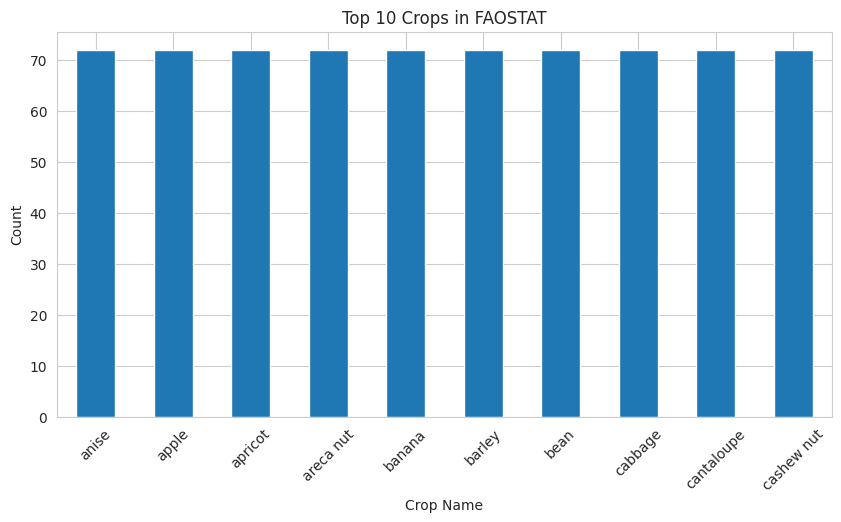

In [126]:
import matplotlib.pyplot as plt

# Count crops and show top 10
top_crops = faostat_df['crop'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_crops.plot(kind='bar')
plt.title("Top 10 Crops in FAOSTAT")
plt.xlabel("Crop Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

**Step 4: Production Over Years (Line Chart)**

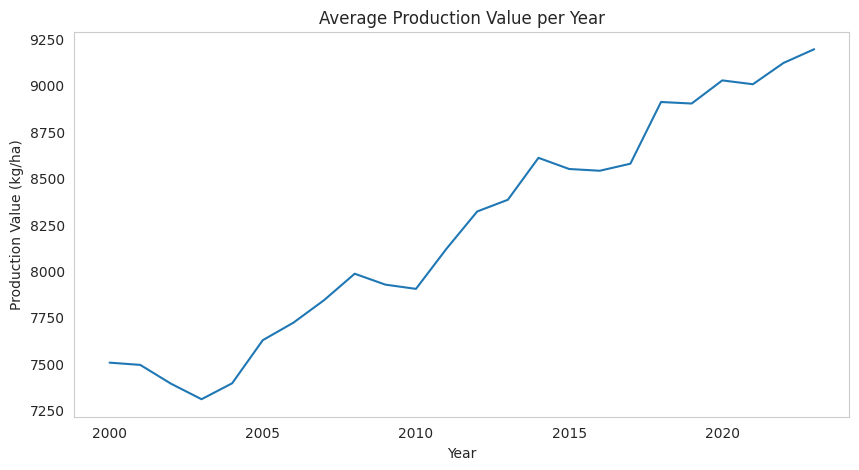

In [128]:
# Group by year and calculate average production value
yearly_production = faostat_df_cleaned.groupby('Year')['Yield_kg_ha'].mean()

plt.figure(figsize=(10,5))
yearly_production.plot(kind='line')
plt.title("Average Production Value per Year")
plt.xlabel("Year")
plt.ylabel("Production Value (kg/ha)")
plt.grid()
plt.show()

**Step 5: Correlation Heatmap (Crop Recommendation Dataset)**

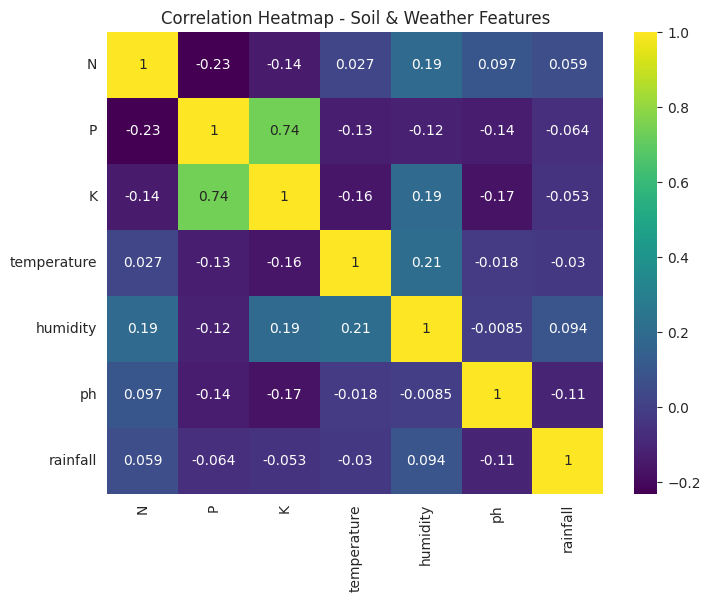

In [134]:
import seaborn as sns

plt.figure(figsize=(8,6))
# Exclude non-numeric columns (like 'crop') when calculating correlation
sns.heatmap(crop_rec_df.drop(columns=['crop']).corr(), annot=True, cmap="viridis")
plt.title("Correlation Heatmap - Soil & Weather Features")
plt.show()

**Step 6: Boxplot to Detect Outliers**

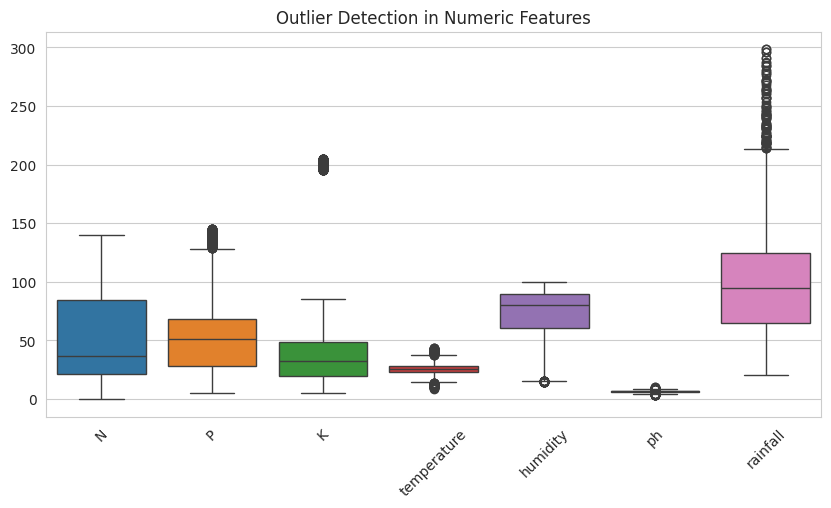

In [135]:
plt.figure(figsize=(10,5))
sns.boxplot(data=crop_rec_df.select_dtypes(include=['float64','int64']))
plt.title("Outlier Detection in Numeric Features")
plt.xticks(rotation=45)
plt.show()


# **Milestone 2: Week 3 & 4 - EDA & Feature Engineering**

### **Performing Exploratory Data Analysis (EDA)**

--- Performing Exploratory Data Analysis (EDA) on df_final_agri_encoded ---


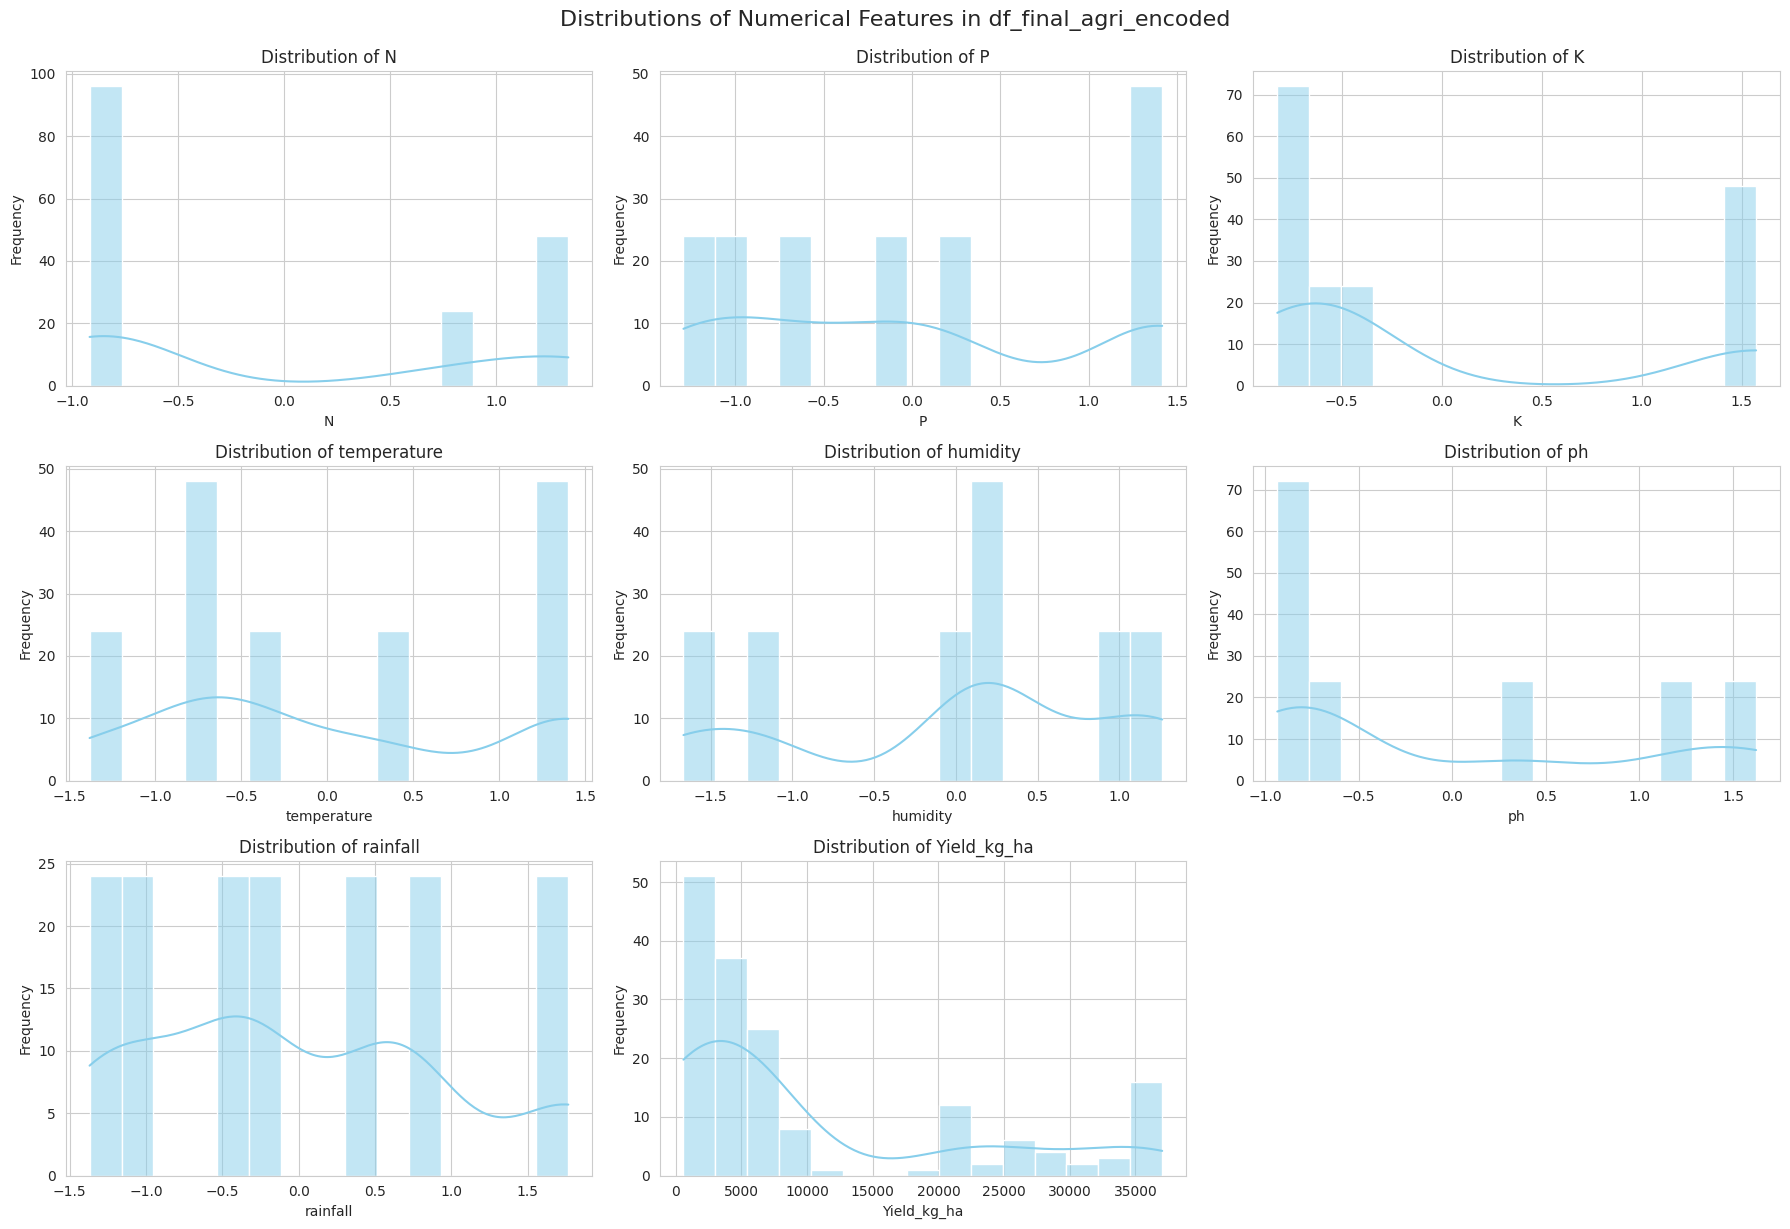

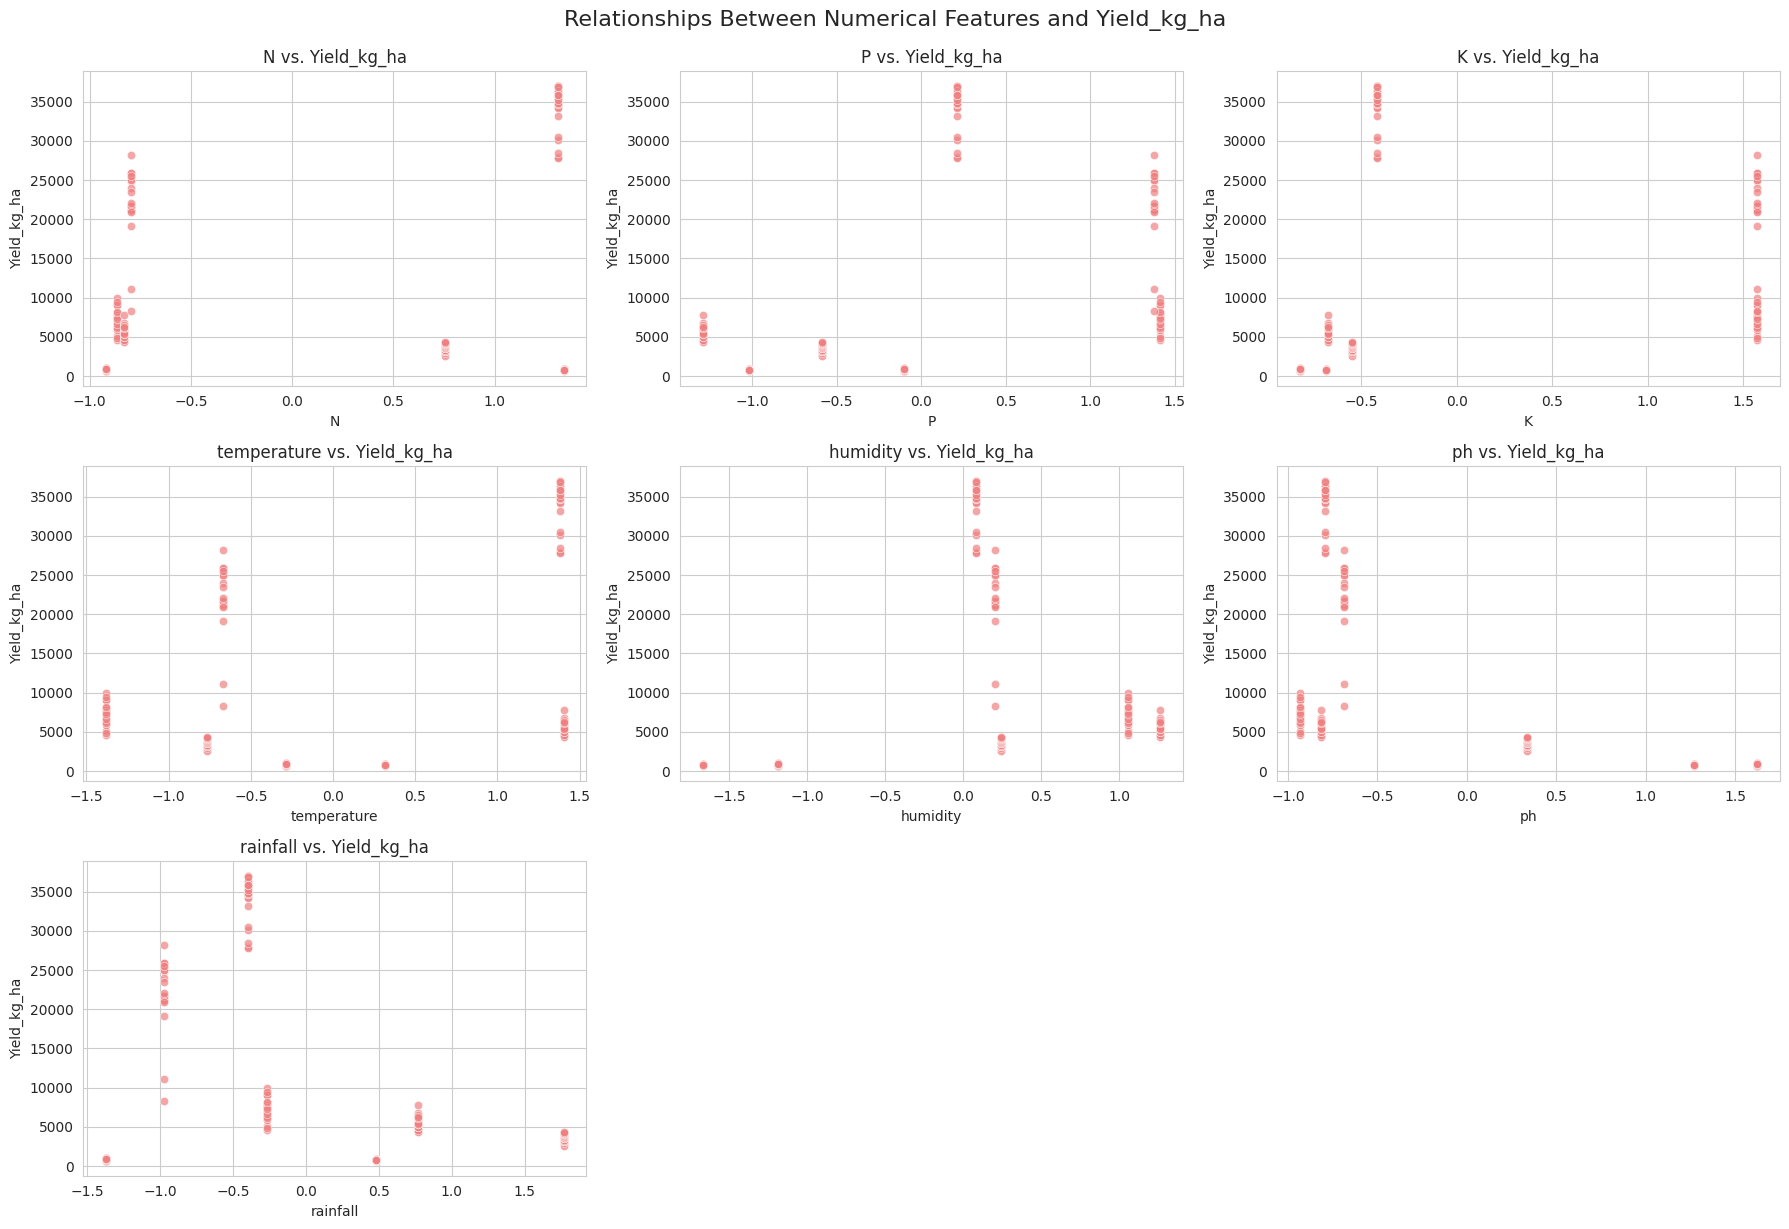


Correlation Matrix of Numerical Features (df_final_agri_encoded):


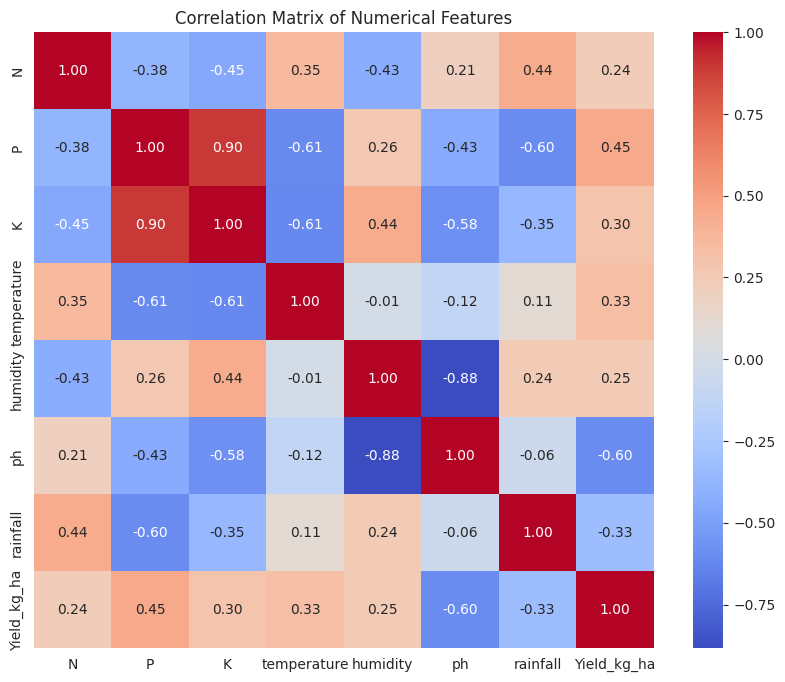


EDA Complete. Visualizations and Correlation Matrix generated.


In [191]:
print('--- Performing Exploratory Data Analysis (EDA) on df_final_agri_encoded ---')

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

# Define numerical features again for clarity, including the target variable
# Exclude Year for correlation analysis if it's treated as a categorical or just for grouping
numerical_features_for_eda = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'Yield_kg_ha']

# Plotting distributions of numerical features
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features_for_eda):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_final_agri_encoded[col], kde=True, bins=15, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.suptitle('Distributions of Numerical Features in df_final_agri_encoded', y=1.02, fontsize=16)
plt.show()

# Plotting relationships between numerical features and 'Yield_kg_ha'
plt.figure(figsize=(18, 12))
for i, col in enumerate(numerical_features_for_eda[:-1]): # Exclude 'Yield_kg_ha' from independent variables
    plt.subplot(3, 3, i + 1)
    sns.scatterplot(x=df_final_agri_encoded[col], y=df_final_agri_encoded['Yield_kg_ha'], color='lightcoral', alpha=0.7)
    plt.title(f'{col} vs. Yield_kg_ha')
    plt.xlabel(col)
    plt.ylabel('Yield_kg_ha')
plt.tight_layout()
plt.suptitle('Relationships Between Numerical Features and Yield_kg_ha', y=1.02, fontsize=16)
plt.show()

print('\nCorrelation Matrix of Numerical Features (df_final_agri_encoded):')
# Calculate and display the correlation matrix for numerical features only
corr_matrix_final = df_final_agri_encoded[numerical_features_for_eda].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_final, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print('\nEDA Complete. Visualizations and Correlation Matrix generated.')

Text(0.5, 0.98, 'FAOSTAT - Overview')

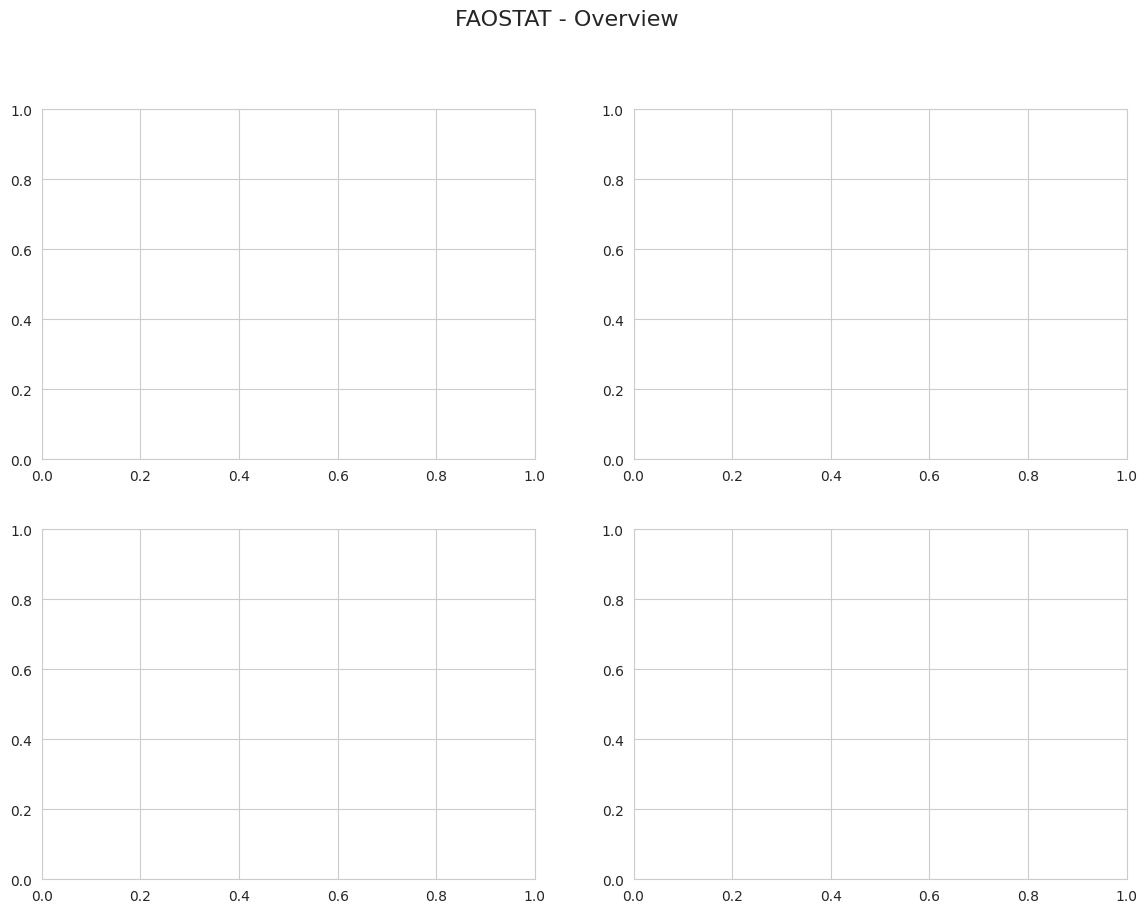

In [192]:
# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("FAOSTAT - Overview", fontsize=16)

In [194]:
# 4) Correlation heatmap (numeric columns)
numeric_df = faostat_df_cleaned.select_dtypes(include=['int64', 'float64'])
if numeric_df.shape[1] > 1:
    sns.heatmap(numeric_df.corr(), ax=axes[1, 1], annot=False)
    axes[1, 1].set_title("Correlation Heatmap (Numeric)")
else:
    axes[1, 1].text(0.5, 0.5, "Not enough numeric columns", ha='center')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for title
plt.show()

<Figure size 640x480 with 0 Axes>

## Encoding categorical feature

In [196]:
print("--- Encoding categorical features in df_final_agri ---")

# Apply one-hot encoding to 'Country' and 'crop' columns in df_final_agri
df_final_agri_encoded = pd.get_dummies(df_final_agri, columns=['Country', 'crop'], drop_first=True)

print("\nShape of df_final_agri after one-hot encoding:" , df_final_agri_encoded.shape)
print("\nFirst 5 rows of df_final_agri_encoded:")
display(df_final_agri_encoded.head())
print("\nData types of df_final_agri_encoded after encoding:")
print(df_final_agri_encoded.info())

--- Encoding categorical features in df_final_agri ---

Shape of df_final_agri after one-hot encoding: (168, 15)

First 5 rows of df_final_agri_encoded:


,Year,Yield_kg_ha,N,P,K,temperature,humidity,ph,rainfall,crop_banana,crop_coconut,crop_coffee,crop_grapes,crop_lentil,crop_rice
0,2000,4565.2,20.8,134.22,199.89,22.630942,92.333383,5.929663,112.654779,False,False,False,False,False,False
1,2001,5125.0,20.8,134.22,199.89,22.630942,92.333383,5.929663,112.654779,False,False,False,False,False,False
2,2002,4833.3,20.8,134.22,199.89,22.630942,92.333383,5.929663,112.654779,False,False,False,False,False,False
3,2003,5880.0,20.8,134.22,199.89,22.630942,92.333383,5.929663,112.654779,False,False,False,False,False,False
4,2004,7562.6,20.8,134.22,199.89,22.630942,92.333383,5.929663,112.654779,False,False,False,False,False,False



Data types of df_final_agri_encoded after encoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          168 non-null    int64  
 1   Yield_kg_ha   168 non-null    float64
 2   N             168 non-null    float64
 3   P             168 non-null    float64
 4   K             168 non-null    float64
 5   temperature   168 non-null    float64
 6   humidity      168 non-null    float64
 7   ph            168 non-null    float64
 8   rainfall      168 non-null    float64
 9   crop_banana   168 non-null    bool   
 10  crop_coconut  168 non-null    bool   
 11  crop_coffee   168 non-null    bool   
 12  crop_grapes   168 non-null    bool   
 13  crop_lentil   168 non-null    bool   
 14  crop_rice     168 non-null    bool   
dtypes: bool(6), float64(8), int64(1)
memory usage: 12.9 KB
None


In [188]:
print("--- Applying feature scaling (Standardization) to numerical features ---")

from sklearn.preprocessing import StandardScaler

# Identify numerical columns for scaling
# Exclude 'Year' and 'Yield_kg_ha' (our target variable), and the newly created dummy variables (which are boolean/int)
numerical_cols_to_scale = [
    'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'
]

# Initialize StandardScaler
scaler = StandardScaler()

# Apply standardization to the numerical columns
df_final_agri_encoded[numerical_cols_to_scale] = scaler.fit_transform(df_final_agri_encoded[numerical_cols_to_scale])

print("\nFirst 5 rows of df_final_agri_encoded after scaling:")
display(df_final_agri_encoded.head())
print("\nDescriptive statistics of scaled numerical features:")
print(df_final_agri_encoded[numerical_cols_to_scale].describe().to_markdown(numalign="left", stralign="left"))

--- Applying feature scaling (Standardization) to numerical features ---

First 5 rows of df_final_agri_encoded after scaling:


,Year,Yield_kg_ha,N,P,K,temperature,humidity,ph,rainfall,crop_banana,crop_coconut,crop_coffee,crop_grapes,crop_lentil,crop_rice
0,2000,4565.2,-0.86246,1.414906,1.569088,-1.380036,1.05835,-0.933833,-0.267856,False,False,False,False,False,False
1,2001,5125.0,-0.86246,1.414906,1.569088,-1.380036,1.05835,-0.933833,-0.267856,False,False,False,False,False,False
2,2002,4833.3,-0.86246,1.414906,1.569088,-1.380036,1.05835,-0.933833,-0.267856,False,False,False,False,False,False
3,2003,5880.0,-0.86246,1.414906,1.569088,-1.380036,1.05835,-0.933833,-0.267856,False,False,False,False,False,False
4,2004,7562.6,-0.86246,1.414906,1.569088,-1.380036,1.05835,-0.933833,-0.267856,False,False,False,False,False,False



Descriptive statistics of scaled numerical features:
|       | N            | P           | K           | temperature   | humidity     | ph           | rainfall    |
|:------|:-------------|:------------|:------------|:--------------|:-------------|:-------------|:------------|
| count | 168          | 168         | 168         | 168           | 168          | 168          | 168         |
| mean  | -4.22942e-17 | 1.16309e-16 | 5.81545e-17 | 3.38354e-16   | -8.45884e-17 | -1.26883e-15 | 1.21596e-16 |
| std   | 1.00299      | 1.00299     | 1.00299     | 1.00299       | 1.00299      | 1.00299      | 1.00299     |
| min   | -0.918054    | -1.2919     | -0.821067   | -1.38004      | -1.66671     | -0.933833    | -1.37013    |
| 25%   | -0.86246     | -1.01935    | -0.681615   | -0.763723     | -1.18341     | -0.813709    | -0.976263   |
| 50%   | -0.797282    | -0.105004   | -0.550109   | -0.28639      | 0.206704     | -0.687244    | -0.267856   |
| 75%   | 1.3128       | 1.3759      | 1.5

# **Target Variable Distribution (Crop Yield)**

**Distribution Plot (Histogram + KDE)**

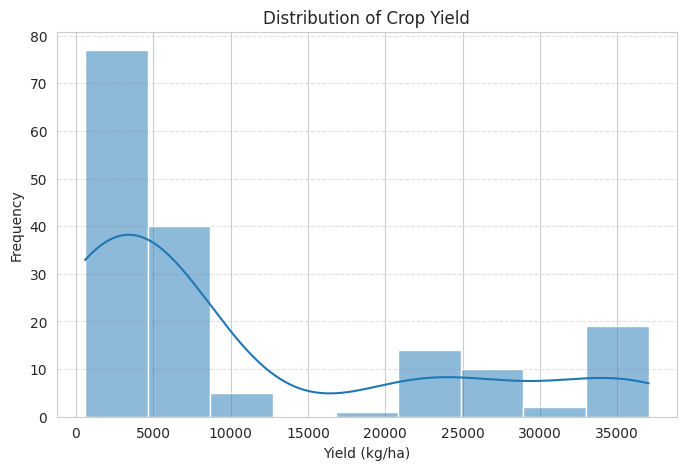

In [198]:
plt.figure(figsize=(8,5))
sns.histplot(df_final_agri_encoded['Yield_kg_ha'], kde=True)
plt.title("Distribution of Crop Yield")
plt.xlabel("Yield (kg/ha)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Boxplot for Outlier Detection**

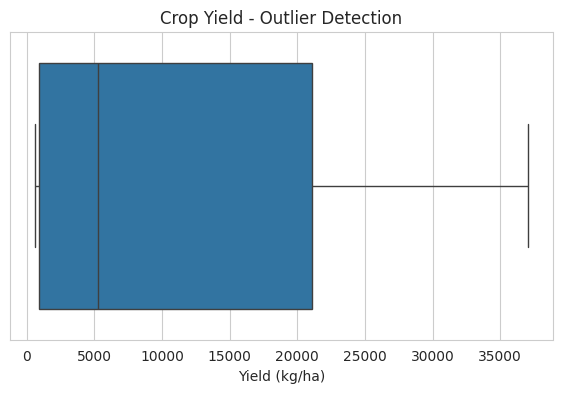

In [203]:
plt.figure(figsize=(7,4))
sns.boxplot(x=df_final_agri_encoded['Yield_kg_ha'])
plt.title("Crop Yield - Outlier Detection")
plt.xlabel("Yield (kg/ha)")
plt.show()


**Statistical Summary**

In [220]:
summary_stats = df_final_agri_encoded['Yield_kg_ha'].describe()
print(" Crop Yield Statistical Summary:")
print(summary_stats)

 Crop Yield Statistical Summary:
count      168.000000
mean     10542.520238
std      11906.026282
min        590.800000
25%        929.125000
50%       5283.200000
75%      21081.800000
max      37036.700000
Name: Yield_kg_ha, dtype: float64


**Check Skewness**

In [213]:
skew_value = df_final_agri_encoded['Yield_kg_ha'].skew()
print(f" Skewness of Crop Yield: {skew_value:.2f}")

 Skewness of Crop Yield: 1.13


# **Feature-Level Analysis**

### **• Numeric (Histograms, Boxplots)**

### **• Categorical (Value Counts, Bar Charts)**


# **Feature vs Yield Relationship**

### **• Correlation Matrix / Heatmap**

###**• Scatter Plots & Boxplots**

# **Feature Importance (Preliminary Model)**

# **Feature Engineering**

### **• Growing Season Index**

### **• Heat Stress & Rainfall Indicators**

### **• Soil Fertility Score**

# **Categorical Encoding Plan**

# **Scaling & Preprocessing Pipeline Setup**

# **Milestone 3: Week 5 & 6 — Model Development & Evaluation**

# **Define Inputs & Data Pipeline**

# **Baseline Models & Metrics**

### **• Dummy Regressor**

### **• Linear Regression**

# **Train Main Models**

### **• Random Forest Regressor**

### **• XGBoost Regressor**

# **Model Hyperparameter Tuning**

#**Evaluate on Test Data**

### **• RMSE, MAE, R² Comparison Table**

# **Model Interpretation**

### **• Feature Importance**

### **• SHAP Analysis**

# **Select and Save Best Model**

# **Milestone 4: UI for Predictions**

## **Build Prediction Web App (Streamlit)**

## **Model Loading & Input Form**

## **User Prediction & Display Results**

# **Milestone 5 — Final Deployment & Report**

## **Deployment (Render / Local Demo)**

## **Documentation & Future Enhancements**

# **📎 Appendices**

**A. About the Dataset**

**B. Glossary of Features**

**C. References & CitationsEnhancements**